## Problem statement: 
##### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [5]:
import tensorflow
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense , Flatten , Dropout , Input , Conv2D , MaxPooling2D , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# from tensorflow.keras.a
from tensorflow.keras.models import Sequential
import cv2
from tensorflow.keras.optimizers import Adam
import Augmentor

from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint

In [ ]:
!pip install Augmentor

In [2]:
!nvidia-smi

Tue Jul 19 16:40:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/upgrad-image-classification/cnn assignment

/content/drive/.shortcut-targets-by-id/1ed4ktRvRH-vascq6akeZ0yq52vTejFCb/upgrad-image-classification/cnn assignment


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [70]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [71]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing and defining parameters



In [72]:
batch_size = 32
img_height = 180
img_width = 180

### train test split

In [73]:
## Write your train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               image_size =(img_height,img_width),
                                                               seed = 123,
                                                               validation_split=0.2,
                                                               subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [74]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                               image_size =(img_height,img_width),
                                                               seed = 123,
                                                               )

Found 118 files belonging to 9 classes.


In [75]:
## Write your validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             image_size=(img_height,img_width),
                                                             seed = 123,
                                                             subset = 'validation',
                                                             validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [76]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


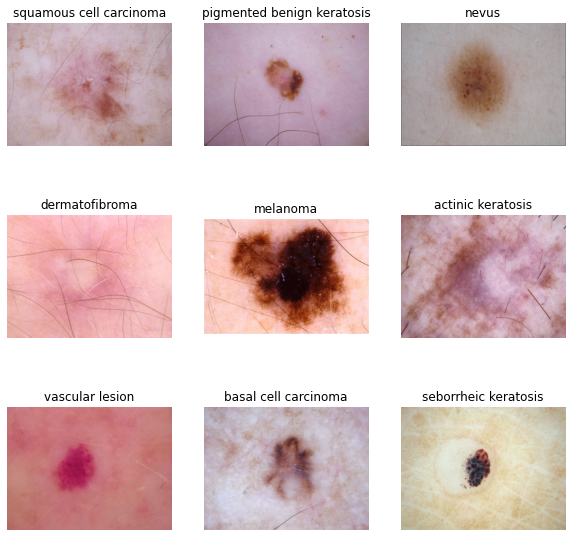

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
i=0
for root,dir,files in os.walk('Skin cancer ISIC The International Skin Imaging Collaboration/Train'):
        if len(files) and i<=8:
            ax = plt.subplot(3, 3, i + 1)
            f = os.path.join(root,files[2])
            # img = c.imread(f)
            img = Image.open(f)
            plt.imshow(img)
            plt.title(root.split('/')[-1])
            plt.axis("off")
            i+=1
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [78]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [79]:
### raw model architecture

input = Input(shape = (img_height,img_width,3))
x = Rescaling(scale = 1./255)(input)

x = Conv2D(32,3,activation = 'relu' ,padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(32,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(128,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
x = Dense(512,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)

x = Dense(9,activation = 'softmax')(x)

model = tf.keras.Model(inputs = input , outputs = x)

In [80]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_35 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 90, 90, 32)        9248

In [81]:
### Defining callbacks

from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau

csv_log = CSVLogger("saved_model/raw_model_final.csv")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=4, 
    min_lr=0.0001,
    verbose=2
)

## model compile
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

### Train the model

In [82]:
### model training
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks = [csv_log]
)

Epoch 1/20
56/56 [==============================] - 400s 1s/step - loss: 1.7374 - accuracy: 0.3917 - val_loss: 2.4773 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5771 - accuracy: 0.4314 - val_loss: 2.4678 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5098 - accuracy: 0.4732 - val_loss: 3.3755 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4082 - accuracy: 0.4972 - val_loss: 4.4831 - val_accuracy: 0.0582
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3807 - accuracy: 0.5084 - val_loss: 3.8130 - val_accuracy: 0.1700
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3185 - accuracy: 0.5179 - val_loss: 3.4639 - val_accuracy: 0.0984
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2835 - accuracy: 0.5379 - val_loss: 2.0748 - val_accuracy: 0.3333
Epoch 8/20
56

In [83]:
model.save('/content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/raw_model_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/raw_model_final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/raw_model_final/assets


### Visualizing training results

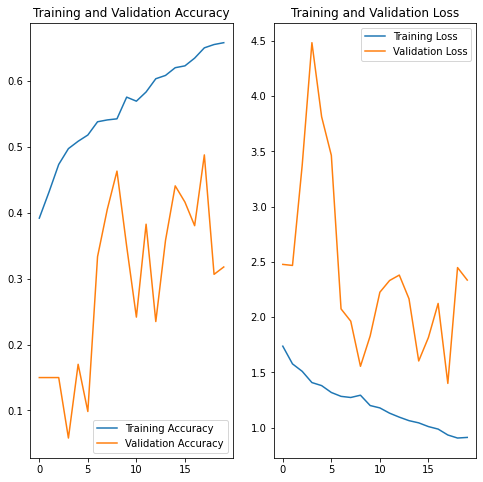

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
- Model doesnt seem to converge , high fluctuation in training and validation accuracy
- Huge gap between validation acuracy and training accuracy indicating overfitting

#### Checking distribution of class labels

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

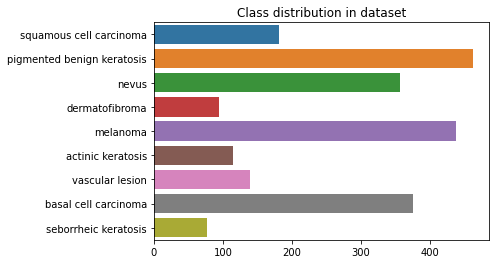

In [86]:

dicty = {}
for root , dirs , files in os.walk('Skin cancer ISIC The International Skin Imaging Collaboration/Train'):
  # print(len(files))
  if len(files):
    class_name = root.split('/')[-1]
    dicty[class_name] = len(files)
sns.barplot(y = list(dicty.keys()),x = list(dicty.values()))
plt.title("Class distribution in dataset")
plt.show()

In [ ]:
dicty

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

### Data Augmentation

In [106]:
### small model to vizualize data augmentation
image_data_augmentation = keras.Sequential([ 
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
])


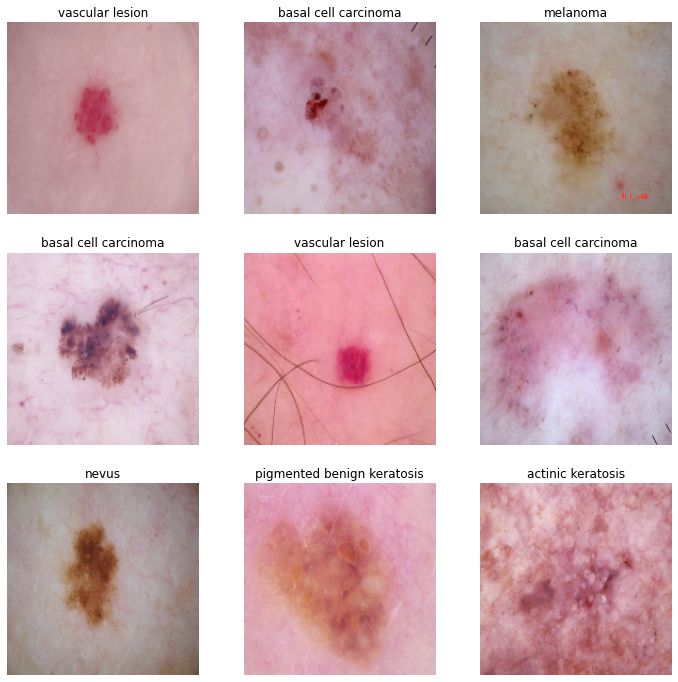

In [111]:
#visualize of augmented image

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model, compile and train the model


In [95]:
### model architecture

input = Input(shape = (img_height,img_width,3)) ## input layer

x = layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3))(input)
x = layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect')(x)
x = Rescaling(scale = 1./255)(x)

x = Conv2D(32,3,activation = 'relu' ,padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(32,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

x = Conv2D(128,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
x = Dense(512,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
x = Dense(9,activation = 'softmax')(x)

model2 = tf.keras.Model(inputs = input , outputs = x)

In [96]:
model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_50 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                         

In [97]:
### defining model callbacks

from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau

## callback to save history at every level
csv_log = CSVLogger("/content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/middle_final/middle.csv")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=2
)

In [98]:
### model compile
model2.compile(optimizer = keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [99]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [reduce_lr,csv_log]
)

Epoch 1/20
56/56 [==============================] - 4s 48ms/step - loss: 1.7528 - accuracy: 0.3655 - val_loss: 2.3243 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5358 - accuracy: 0.4492 - val_loss: 3.5117 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4804 - accuracy: 0.4554 - val_loss: 3.6950 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4109 - accuracy: 0.4810 - val_loss: 5.7196 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3535 - accuracy: 0.5140 - val_loss: 4.4936 - val_accuracy: 0.1745 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3124 - accuracy: 0.5195 - val_loss: 2.2304 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3

### visualiation

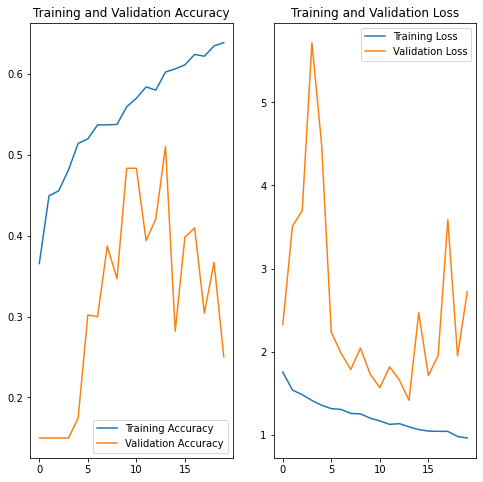

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [101]:
model.save("/content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/middle_final/middle")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/middle_final/middle/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/middle_final/middle/assets


### Findings
- incuded random flip and random rotation as augmentation
- the model seems to fit slightly better than previous one but overfitiing is still present which is indicated by huge gap in training and validation error


#### Class imbalance detection and treatment

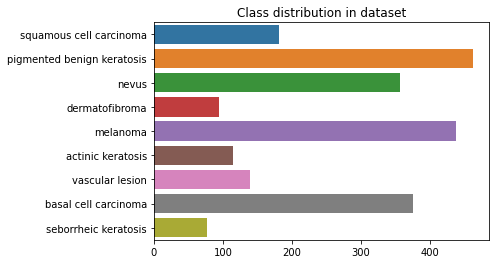

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dicty = {}
for root , dirs , files in os.walk('Skin cancer ISIC The International Skin Imaging Collaboration/Train'):
  # print(len(files))
  if len(files):
    class_name = root.split('/')[-1]
    dicty[class_name] = len(files)
sns.barplot(y = list(dicty.keys()),x = list(dicty.values()))
plt.title("Class distribution in dataset")
plt.show()



#### - Which class has the least number of samples?
##### `answer` - seborrheic keratosis: 77
#### - Which classes dominate the data in terms proportionate number of samples?
##### - `answer` - pigmented benign keratosis = 462


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/upgrad-image-classification/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [ ]:
### total count of new images added
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]


In [ ]:
len(path_list)

2239

In [ ]:
### total no of images after new image added are
import glob
path_list_new = [x for x in glob.glob(os.path.join('/content/drive/MyDrive/upgrad-image-classification/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmented', '*', '*.jpg'))]
len(path_list_new)


6739

In [ ]:
labels = list(set([x.split('/')[-2] for x in path_list ]))

In [ ]:
### combining new created dataset with old training data in a seperate location
import shutil
path = '/content/drive/MyDrive/upgrad-image-classification/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
train_aug = '/content/drive/MyDrive/upgrad-image-classification/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmented/'
for ele in labels:
  p = path+ele
  write = train_aug+ele
  if not os.path.exists(write):
    os.mkdir(write)
  for f in os.listdir(p):
    if len(f.split('.'))==2:
      shutil.copy(os.path.join(p,f),os.path.join(write,f))
    
  for f in os.listdir(os.path.join(p,'output')):
    shutil.copy(os.path.join(os.path.join(p,'output'),f),os.path.join(write,f))
    


## Training using data generated with augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmented"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'Skin cancer ISIC The International Skin Imaging Collaboration/Train_augmented',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [18]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [65]:
#### MODEL ARCHITECTURE

input = Input(shape = (img_height,img_width,3))
x = Rescaling(scale = 1./255)(input)

x = Conv2D(32,3,activation = 'relu' ,padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(32,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

x = Conv2D(128,3,activation = 'relu',padding = 'same' )(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation = 'relu')(x)
x = Dense(512,activation = 'relu')(x)
x = Dropout(.3)(x)
x = Dense(32,activation = 'relu')(x)
x = Dense(9,activation = 'softmax')(x)


model3 = tf.keras.Model(inputs = input , outputs = x)





#### Compile and callbacs defining

In [66]:
### callbacks


### to save model history
csv_log = CSVLogger("saved_model/last6.csv")

### to reduce leraning rate on reagions of plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=4, 
    min_lr=0.0001,
    verbose=2
)

### stoping tarining on to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose=1, 
                               patience=8)
### save best model callback                              
checkpoint_filepath = '/content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint'

model_checkpoint = ModelCheckpoint( filepath=checkpoint_filepath,
                                  
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

In [67]:
### optimiser and loss function
model3.compile(optimizer = keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',])

In [68]:
### MODEL TRAINING
epochs = 50
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [reduce_lr,csv_log,early_stopping,model_checkpoint]
)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 1.7703 - accuracy: 0.3288INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 11s 58ms/step - loss: 1.7703 - accuracy: 0.3288 - val_loss: 2.9430 - val_accuracy: 0.1024 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 7s 41ms/step - loss: 1.5562 - accuracy: 0.4037 - val_loss: 3.6671 - val_accuracy: 0.1574 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 1.4704 - accuracy: 0.4254INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 1.4704 - accuracy: 0.4254 - val_loss: 2.6349 - val_accuracy: 0.2442 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 1.4213 - accuracy: 0.4466INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 1.4213 - accuracy: 0.4466 - val_loss: 2.1443 - val_accuracy: 0.3036 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - ETA: 0s - loss: 1.3482 - accuracy: 0.4751INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 1.3482 - accuracy: 0.4751 - val_loss: 1.3159 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 7s 40ms/step - loss: 1.2886 - accuracy: 0.5065 - val_loss: 1.3806 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - ETA: 0s - loss: 1.2598 - accuracy: 0.5121INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 1.2598 - accuracy: 0.5121 - val_loss: 1.1777 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 8/50
169/169 [==============================] - 7s 40ms/step - loss: 1.1643 - accuracy: 0.5464 - val_loss: 1.6446 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 9/50
169/169 [==============================] - 7s 41ms/step - loss: 1.1214 - accuracy: 0.5631 - val_loss: 1.4257 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 10/50
169/169 [==============================] - 7s 41ms/step - loss: 1.0393 - accuracy: 0.5979 - val_loss: 1.4387 - val_accuracy: 0.4529 - lr: 0.0010
Epoch 11/50
169/169 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.6185
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
169/169 [==============================] - 7s 40ms/step - loss: 0.9720 - accuracy: 0.6185 - val_loss: 3.3716 - val_accuracy: 0.2576 - lr: 0.0010
Epoch 12/50
169/169 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 0.8079 - accuracy: 0.6925 - val_loss: 1.0179 - val_accuracy: 0.5954 - lr: 1.0000e-04
Epoch 13/50
169/169 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.7112INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 0.7530 - accuracy: 0.7112 - val_loss: 0.8187 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 14/50
169/169 [==============================] - 7s 41ms/step - loss: 0.7224 - accuracy: 0.7155 - val_loss: 0.9908 - val_accuracy: 0.6199 - lr: 1.0000e-04
Epoch 15/50
169/169 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.7250INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 58ms/step - loss: 0.7002 - accuracy: 0.7250 - val_loss: 0.7604 - val_accuracy: 0.6956 - lr: 1.0000e-04
Epoch 16/50
169/169 [==============================] - 7s 40ms/step - loss: 0.6773 - accuracy: 0.7339 - val_loss: 0.8282 - val_accuracy: 0.6763 - lr: 1.0000e-04
Epoch 17/50
168/169 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.7362INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 0.6670 - accuracy: 0.7361 - val_loss: 0.7416 - val_accuracy: 0.7112 - lr: 1.0000e-04
Epoch 18/50
169/169 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7511INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 0.6360 - accuracy: 0.7511 - val_loss: 0.7405 - val_accuracy: 0.6949 - lr: 1.0000e-04
Epoch 19/50
169/169 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7517INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 0.6244 - accuracy: 0.7517 - val_loss: 0.7237 - val_accuracy: 0.7112 - lr: 1.0000e-04
Epoch 20/50
169/169 [==============================] - 7s 42ms/step - loss: 0.6116 - accuracy: 0.7533 - val_loss: 0.8059 - val_accuracy: 0.6771 - lr: 1.0000e-04
Epoch 21/50
169/169 [==============================] - 7s 40ms/step - loss: 0.6019 - accuracy: 0.7570 - val_loss: 0.7496 - val_accuracy: 0.7097 - lr: 1.0000e-04
Epoch 22/50
169/169 [==============================] - 7s 40ms/step - loss: 0.5784 - accuracy: 0.7704 - val_loss: 0.7688 - val_accuracy: 0.6986 - lr: 1.0000e-04
Epoch 23/50
169/169 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7774INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 55ms/step - loss: 0.5647 - accuracy: 0.7774 - val_loss: 0.7188 - val_accuracy: 0.7105 - lr: 1.0000e-04
Epoch 24/50
168/169 [============================>.] - ETA: 0s - loss: 0.5546 - accuracy: 0.7810INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 58ms/step - loss: 0.5539 - accuracy: 0.7810 - val_loss: 0.7112 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 25/50
168/169 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.7851INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 0.5479 - accuracy: 0.7851 - val_loss: 0.6688 - val_accuracy: 0.7424 - lr: 1.0000e-04
Epoch 26/50
169/169 [==============================] - 7s 40ms/step - loss: 0.5298 - accuracy: 0.7923 - val_loss: 0.6806 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 27/50
169/169 [==============================] - 7s 41ms/step - loss: 0.5127 - accuracy: 0.7977 - val_loss: 0.6943 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 28/50
169/169 [==============================] - 7s 42ms/step - loss: 0.4969 - accuracy: 0.8012 - val_loss: 0.6986 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 29/50
169/169 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.8029
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001.
169/169 [==============================] - 7s 41ms/step - loss: 0.5019 - accuracy: 0.8029 - val_loss: 0.6860 - val_accuracy: 0.7290 - lr: 1.0000e-04
Epoch 30/50
169/169 [==============================] - ETA: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 59ms/step - loss: 0.4827 - accuracy: 0.8086 - val_loss: 0.6349 - val_accuracy: 0.7513 - lr: 1.0000e-04
Epoch 31/50
169/169 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.8186INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 56ms/step - loss: 0.4667 - accuracy: 0.8186 - val_loss: 0.5928 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 32/50
169/169 [==============================] - 7s 41ms/step - loss: 0.4559 - accuracy: 0.8199 - val_loss: 0.7640 - val_accuracy: 0.7171 - lr: 1.0000e-04
Epoch 33/50
169/169 [==============================] - 7s 40ms/step - loss: 0.4505 - accuracy: 0.8260 - val_loss: 0.6225 - val_accuracy: 0.7558 - lr: 1.0000e-04
Epoch 34/50
169/169 [==============================] - 7s 41ms/step - loss: 0.4351 - accuracy: 0.8231 - val_loss: 0.6310 - val_accuracy: 0.7558 - lr: 1.0000e-04
Epoch 35/50
169/169 [==============================] - 7s 41ms/step - loss: 0.4221 - accuracy: 0.8333 - val_loss: 0.7278 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 36/50
169/169 [==============================] - 7s 40ms/step - loss: 0.4154 - accuracy: 0.8348 - val_loss: 0.6079 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 37/50
169/169 [=========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 58ms/step - loss: 0.3822 - accuracy: 0.8498 - val_loss: 0.5861 - val_accuracy: 0.7869 - lr: 1.0000e-04
Epoch 40/50
169/169 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8490INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 9s 55ms/step - loss: 0.3748 - accuracy: 0.8490 - val_loss: 0.5464 - val_accuracy: 0.7996 - lr: 1.0000e-04
Epoch 41/50
169/169 [==============================] - 7s 40ms/step - loss: 0.3610 - accuracy: 0.8583 - val_loss: 0.6350 - val_accuracy: 0.7565 - lr: 1.0000e-04
Epoch 42/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3606 - accuracy: 0.8542 - val_loss: 0.6491 - val_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 43/50
169/169 [==============================] - 7s 40ms/step - loss: 0.3464 - accuracy: 0.8641 - val_loss: 0.6333 - val_accuracy: 0.7632 - lr: 1.0000e-04
Epoch 44/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3353 - accuracy: 0.8702 - val_loss: 0.7646 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 45/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3297 - accuracy: 0.8731 - val_loss: 0.5802 - val_accuracy: 0.7899 - lr: 1.0000e-04
Epoch 46/50
169/169 [=========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last6/checkpoint/assets


169/169 [==============================] - 10s 57ms/step - loss: 0.3132 - accuracy: 0.8795 - val_loss: 0.5430 - val_accuracy: 0.7936 - lr: 1.0000e-04
Epoch 47/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3093 - accuracy: 0.8789 - val_loss: 0.5610 - val_accuracy: 0.8003 - lr: 1.0000e-04
Epoch 48/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3067 - accuracy: 0.8780 - val_loss: 0.6533 - val_accuracy: 0.7699 - lr: 1.0000e-04
Epoch 49/50
169/169 [==============================] - 7s 40ms/step - loss: 0.2995 - accuracy: 0.8804 - val_loss: 0.5548 - val_accuracy: 0.7988 - lr: 1.0000e-04
Epoch 50/50
169/169 [==============================] - 7s 41ms/step - loss: 0.3001 - accuracy: 0.8872 - val_loss: 0.6081 - val_accuracy: 0.7684 - lr: 1.0000e-04


In [39]:
model3.save("/content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last5_checkpoint/last5_bestone")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last5_checkpoint/last5_bestone/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/upgrad-image-classification/cnn assignment/saved_model/last5_checkpoint/last5_bestone/assets


####   Visualize the model results

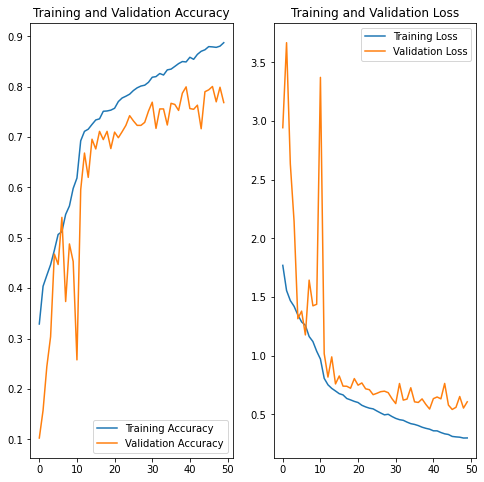

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Analysis - 
- Adding new augmeneted data helped to overcome overfitting of data
- the model seems to have fit well now and does not seem to ovefit
- the best model has the following parameters 

  - loss: 0.3132 
  - accuracy: 0.8795 
  - val_loss: 0.5430 
  - val_accuracy: 0.7936

- for further improvement we need to add more new unique data points


